<a href="https://colab.research.google.com/github/All4Nothing/pytorch-DL-project/blob/main/Ch08_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DCGAN

In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable


import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision import datasets

In [2]:
num_eps=10
bsize=32 # batch size
lrate=0.001 # learning rate
lat_dimension=64 # random noisze vector length
image_sz=64
chnls=1
logging_intv=200

### Define Model

In [29]:
class GANGenerator(nn.Module):
    def __init__(self):
        super(GANGenerator, self).__init__()
        self.inp_sz = image_sz // 4
        self.lin = nn.Linear(lat_dimension, 128 * self.inp_sz ** 2)
        self.bn1 = nn.BatchNorm2d(128)
        self.up1 = nn.Upsample(scale_factor=2)
        self.cn1 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128, 0.8)
        self.rl1 = nn.LeakyReLU(0.2, inplace=True)
        self.up2 = nn.Upsample(scale_factor=2)
        self.cn2 = nn.Conv2d(128, 64, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64, 0.8)
        self.rl2 = nn.LeakyReLU(0.2, inplace=True)
        self.cn3 = nn.Conv2d(64, chnls, 3, stride=1, padding=1)
        self.act = nn.Tanh()

    def forward(self, x):
        x = self.lin(x)
        x = x.view(x.shape[0], 128, self.inp_sz, self.inp_sz)
        x = self.bn1(x)
        x = self.up1(x)
        x = self.cn1(x)
        x = self.bn2(x)
        x = self.rl1(x)
        x = self.up2(x)
        x = self.cn2(x)
        x = self.bn3(x)
        x = self.rl2(x)
        x = self.cn3(x)
        out = self.act(x)
        return out

super(Class, self).__init__() : Class의 부모를 상속해옴. 명시해주는 기능이다.

In [22]:
class GANGenerator2(nn.Module):
  def __init__(self):
      super(GANGenerator, self).__init__() # super(Class, self).__init__() : Class의 부모를 상속해옴. 명시해주는 기능이다.
      self.inp_sz = image_sz // 4
      self.lin = nn.Linear(lat_dimension, 128 * self.inp_sz ** 2)
      self.bn1 = nn.BatchNorm2d(128)
      self.up1 = nn.Upsample(scale_factor=2)
      self.cn1 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
      self.bn2 = nn.BatchNorm2d(128, 0.8)
      self.rl1 = nn.LeakyReLU(0.2, inplace=True)
      self.cn2 = nn.Conv2d(128, 64, 3, stride=1, padding=1)
      self.bn3 = nn.BatchNorm2d(64, 0.8)
      self.cn3 = nn.Conv2d(64, chnls, 3, stride=1, padding=1)
      self.act = nn.Tanh()
      # delete up2, rl2

  def forward(self, x):
      # debugging의 용의성을 위해 nn.Sequential 대신 각 layer마다 정의
      x = self.lin(x)
      x = x.view(x.shape[0], 128, self.inp_sz, self.inp_sz)
      x = self.bn1(x)
      x = self.up1(x)
      x = self.cn1(x)
      x = self.bn2(x)
      x = self.rl1(x)
      x = self.up1(x)
      x = self.cn2(x)
      x = self.bn3(x)
      x = self.rl1(x)
      x = self.cn3(x)
      out = self.act(x)
      return out

In [30]:
class GANDiscriminator(nn.Module):
    def __init__(self):
        super(GANDiscriminator, self).__init__()

        def disc_module(ip_chnls, op_chnls, bnorm=True):
            mod = [nn.Conv2d(ip_chnls, op_chnls, 3, 2, 1),
                   nn.LeakyReLU(0.2, inplace=True),
                   nn.Dropout2d(0.25)]
            if bnorm:
                mod += [nn.BatchNorm2d(op_chnls, 0.8)]
            return mod

        self.disc_model = nn.Sequential(
            *disc_module(chnls, 16, bnorm=False),
            *disc_module(16, 32),
            *disc_module(32, 64),
            *disc_module(64, 128),
        )

        # width and height of the down-sized image
        ds_size = image_sz // 2 ** 4
        self.adverse_lyr = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, x):
        x = self.disc_model(x)
        x = x.view(x.shape[0], -1)
        out = self.adverse_lyr(x)
        return out

In [31]:
# instantiate the discriminator and generator models
gen = GANGenerator()
disc = GANDiscriminator()

# define the loss metric
adv_loss_func = torch.nn.BCELoss()

In [32]:
# define the dataset and corresponding dataloader
dloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data/mnist/",
        download=True,
        transform=transforms.Compose(
            [transforms.Resize((image_sz, image_sz)),
             transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=bsize,
    shuffle=True,
)

In [33]:
# define the optimization schedule for both G and D
opt_gen = torch.optim.Adam(gen.parameters(), lr=lrate)
opt_disc = torch.optim.Adam(disc.parameters(), lr=lrate)

### Train

In [34]:
os.makedirs("./images_mnist", exist_ok=True)

for ep in range(num_eps):
    for idx, (images, _) in enumerate(dloader):

        # generate grounnd truths for real and fake images
        good_img = Variable(torch.FloatTensor(images.shape[0], 1).fill_(1.0), requires_grad=False)
        bad_img = Variable(torch.FloatTensor(images.shape[0], 1).fill_(0.0), requires_grad=False)

        # get a real image
        actual_images = Variable(images.type(torch.FloatTensor))

        # train the generator model
        opt_gen.zero_grad()

        # generate a batch of images based on random noise as input
        noise = Variable(torch.FloatTensor(np.random.normal(0, 1, (images.shape[0], lat_dimension))))
        gen_images = gen(noise)

        # generator model optimization - how well can it fool the discriminator
        generator_loss = adv_loss_func(disc(gen_images), good_img)
        generator_loss.backward()
        opt_gen.step()

        # train the discriminator model
        opt_disc.zero_grad()

        # calculate discriminator loss as average of mistakes(losses) in confusing real images as fake and vice versa
        actual_image_loss = adv_loss_func(disc(actual_images), good_img)
        fake_image_loss = adv_loss_func(disc(gen_images.detach()), bad_img)
        discriminator_loss = (actual_image_loss + fake_image_loss) / 2

        # discriminator model optimization
        discriminator_loss.backward()
        opt_disc.step()

        batches_completed = ep * len(dloader) + idx
        if batches_completed % logging_intv == 0:
            print(f"epoch number {ep} | batch number {idx} | generator loss = {generator_loss.item()} | discriminator loss = {discriminator_loss.item()}")
            save_image(gen_images.data[:25], f"images_mnist/{batches_completed}.png", nrow=5, normalize=True)


epoch number 0 | batch number 0 | generator loss = 0.7043826580047607 | discriminator loss = 0.692736029624939
epoch number 0 | batch number 200 | generator loss = 1.0467628240585327 | discriminator loss = 0.6641117334365845
epoch number 0 | batch number 400 | generator loss = 5.5562262535095215 | discriminator loss = 0.007224977016448975
epoch number 0 | batch number 600 | generator loss = 1.5227510929107666 | discriminator loss = 0.6235290169715881
epoch number 0 | batch number 800 | generator loss = 0.8410946130752563 | discriminator loss = 0.3491014540195465
epoch number 0 | batch number 1000 | generator loss = 1.7691270112991333 | discriminator loss = 0.45042139291763306
epoch number 0 | batch number 1200 | generator loss = 1.2224516868591309 | discriminator loss = 0.36060965061187744
epoch number 0 | batch number 1400 | generator loss = 0.7980737090110779 | discriminator loss = 0.5121361613273621
epoch number 0 | batch number 1600 | generator loss = 1.3347861766815186 | discrimin

KeyboardInterrupt: ignored

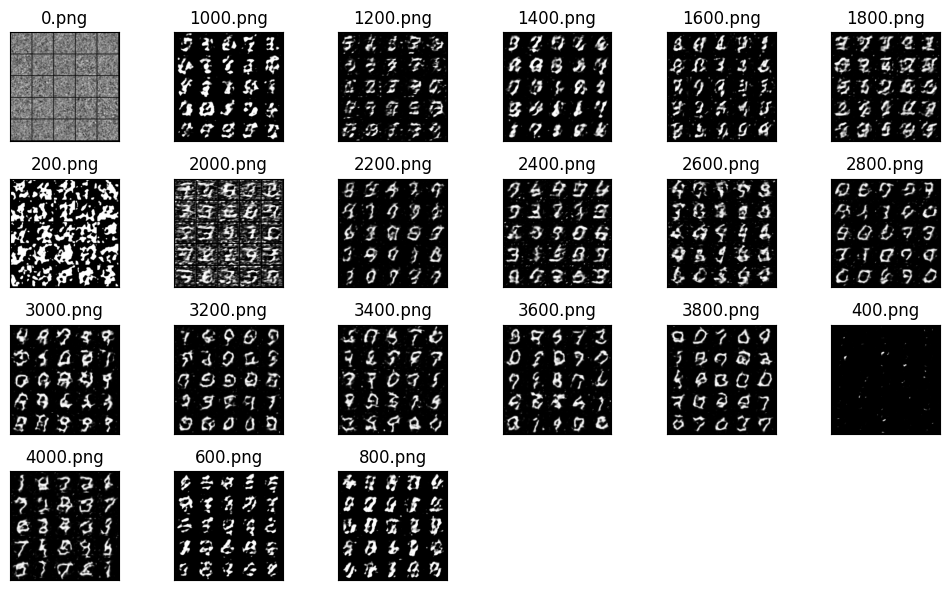

In [59]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(10, 6))
path = './images_mnist/'
files = os.listdir(path)


for i, filename in enumerate(sorted(files)):
    ax = plt.subplot(4, len(files)//4+1, i+1)

    image = mpimg.imread(path+filename)

    ax.imshow(image)

    ax.set_title(filename)

    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

plt.show()
